<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebook/CNN_2_Kaggle_MRI_UNET_BCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 我們要完成的事情
- 到 kaggle 下載 $\Rightarrow$ 可以用 token
- 資料都是在目錄結構，整理成 dataframe

    $\Rightarrow$ 考慮用 data_from_frame

    $\Rightarrow$ 將 str 含與不含 **"mask"** 區隔，放進一個 dataframe 的兩個 columns 裡頭。

    $\Rightarrow$ 如果要只針對 有腫瘤的 mask，可以加一欄標註，當然從 mask matrix 就可以判斷出又沒有腫瘤
- data_generator 設計
- UNET 設計 $\Rightarrow$ 
  - 可以學習設計 resnet block, unet structure
  - keras.models.Model 的寫法
  - 可以研究為什麼要 resnet
- compile and fit
- 熟悉 matplotlib.pyplot, plt.imshow(plt.imread(filename))
- further practice:
  - focal error design



In [ ]:
import json
import os
import os.path
from IPython.display import clear_output as clear

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

from skimage import io
# 遇到一個要填寫 matrix 值，結果 plt.imread() array  不給改寫...

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

#from tensorflow.keras.utils import plot_model
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#import tensorflow.keras.backend as K

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 下載 Kaggle 資料
### 請先登入 Kaggle，在網頁右上角，點選個人帳號圖示，進入設定，然後啟動 “Create New API Token”，將會產生個人 API json 檔同時自動下載到個人電腦。
### 將收到的 json 檔裡頭的 username 與 key 填入下一格中的 api_token 中。



In [ ]:
'''
!cp drive/MyDrive/kaggle_token.py ./kaggle_token.py
from kaggle_token import token
api_token = token("3b8")

#api_token = {"username":"username@Kaggle_token","key":"Kaggle_token"}

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
#if not os.path.exists("/content/kaggle"):
#    os.makedirs("/content/kaggle")
os.chdir('/content')
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
#!kaggle competitions download -c facial-keypoints-detection
!unzip lgg-mri-segmentation.zip 

#!unzip facial-keypoints-detection.zip 
# df = pd.read_csv('kaggle_3m/data.csv')
clear()
del api_token
!rm kaggle_token.py
'''

'\n!cp drive/MyDrive/kaggle_token.py ./kaggle_token.py\nfrom kaggle_token import token\napi_token = token("3b8")\n\n#api_token = {"username":"username@Kaggle_token","key":"Kaggle_token"}\n\nif not os.path.exists("/root/.kaggle"):\n    os.makedirs("/root/.kaggle")\n \nwith open(\'/root/.kaggle/kaggle.json\', \'w\') as file:\n    json.dump(api_token, file)\n!chmod 600 /root/.kaggle/kaggle.json\n \n#if not os.path.exists("/content/kaggle"):\n#    os.makedirs("/content/kaggle")\nos.chdir(\'/content\')\n!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation\n#!kaggle competitions download -c facial-keypoints-detection\n!unzip lgg-mri-segmentation.zip \n\n#!unzip facial-keypoints-detection.zip \n# df = pd.read_csv(\'kaggle_3m/data.csv\')\nclear()\ndel api_token\n!rm kaggle_token.py\n'

In [ ]:

api_token = {"username":"","key":""}

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
#if not os.path.exists("/content/kaggle"):
#    os.makedirs("/content/kaggle")
os.chdir('/content')
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
#!kaggle competitions download -c facial-keypoints-detection
!unzip lgg-mri-segmentation.zip 

#!unzip facial-keypoints-detection.zip 
# df = pd.read_csv('kaggle_3m/data.csv')
clear()
del api_token


In [ ]:
Main_Path = Path("lgg-mri-segmentation/kaggle_3m")
Tif_Path = list(Main_Path.glob(r"*/*.tif")) #似乎不加 r 也可以
Common_Series = pd.Series(Tif_Path,name="GENERAL").astype(str)
Image_Series = pd.Series(Common_Series[~Common_Series.str.contains("mask")]) # have not "mask"
Mask_Series = pd.Series(Common_Series[Common_Series.str.contains("mask")]) # have "mask"

Image_Series = Image_Series.reset_index(drop=True)
Mask_Series = Mask_Series.reset_index(drop=True)

Main_LEN = len("lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_")
IMG_EndPath_LEN = len(".tif") 
MASK_EndPath_LEN = len("_mask.tif")

Image_Series = sorted(Image_Series.values,key=lambda x : int(x[Main_LEN:-IMG_EndPath_LEN]))
Mask_Series = sorted(Mask_Series.values,key=lambda x : int(x[Main_LEN:-MASK_EndPath_LEN]))

In [ ]:
# make dataframe 
Main_Data = {"IMAGE":Image_Series,"MASK":Mask_Series}
Main_Data = pd.DataFrame(Main_Data)

Mask_1_0_sum = []
for i in range(len(Main_Data["MASK"])):
    Mean_Result = np.mean(plt.imread(Main_Data["MASK"][i]))
    
    if Mean_Result > 0:
        Mask_1_0_sum.append(1) # tumor
    else:
        Mask_1_0_sum.append(0) # no tumor   
Main_Data["Mask_1_0"] = Mask_1_0_sum   

In [ ]:
Main_Data

IMAGE  ... Mask_1_0
0     lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19...  ...        0
1     lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19...  ...        0
2     lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19...  ...        0
3     lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19...  ...        0
4     lgg-mri-segmentation/kaggle_3m/TCGA_FG_6692_20...  ...        0
...                                                 ...  ...      ...
3924  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...  ...        0
3925  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...  ...        0
3926  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...  ...        0
3927  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20...  ...        0
3928  lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...  ...        0

[3929 rows x 3 columns]

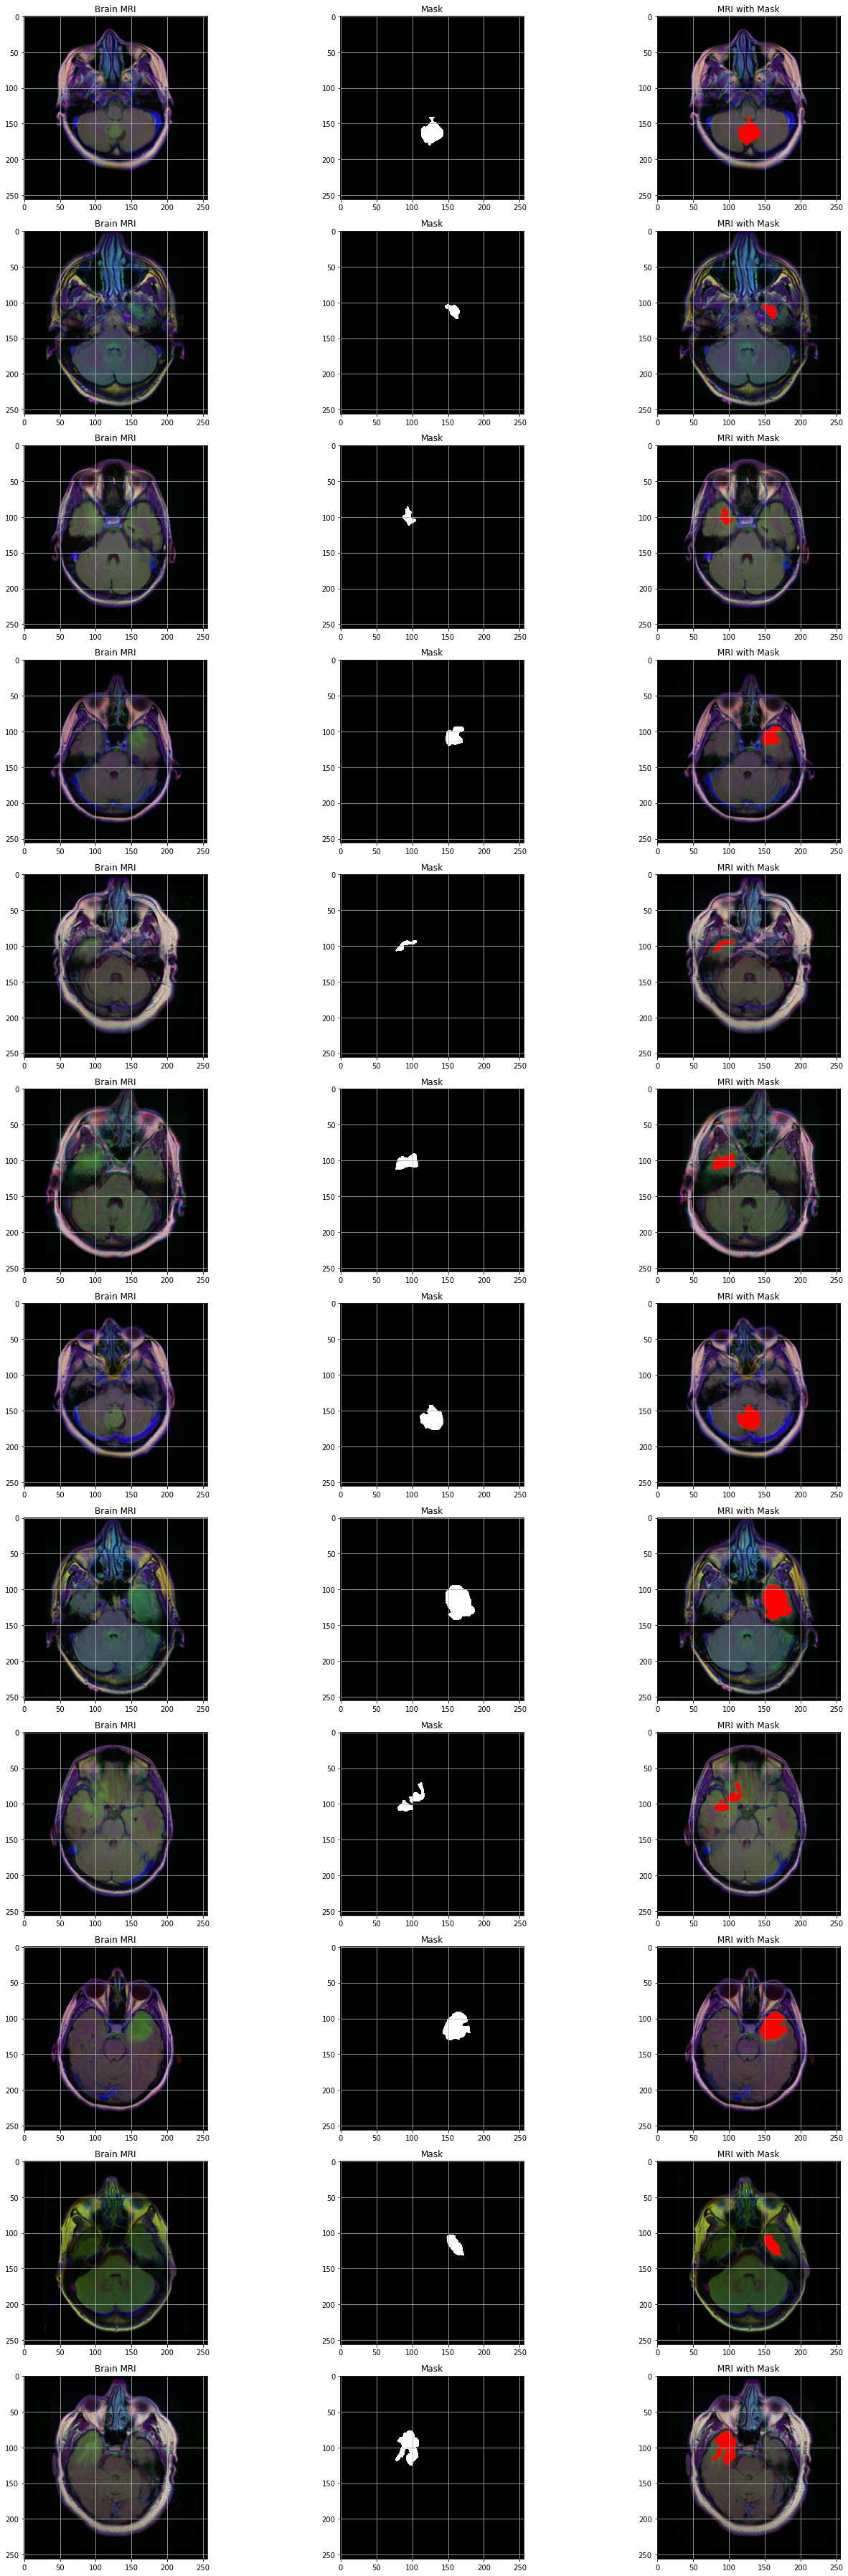

In [ ]:
# if we adapt plt, it shown "assignment destination is read-only"

count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(Main_Data)):
  if Main_Data['Mask_1_0'][i] ==1 and count <12:
    #print(i)
    img = io.imread(Main_Data.IMAGE[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)
    axs[count][0].grid()

    mask = io.imread(Main_Data.MASK[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask, cmap = 'gray')
    axs[count][1].grid()

    
    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI with Mask')
    axs[count][2].imshow(img)
    axs[count][2].grid()
    count+=1

fig.tight_layout()

## Data Preparation 

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Get the number of batches per epoch'

    return int(np.floor(len(self.ids)) / self.batch_size)

  def __getitem__(self, index):
    'Generate a batch of data'

    #generate index of batch_size length
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]

    #get the ImageId corresponding to the indexes created above based on batch size
    list_ids = [self.ids[i] for i in indexes]

    #get the MaskId corresponding to the indexes created above based on batch size
    list_mask = [self.mask[i] for i in indexes]


    #generate data for the X(features) and y(label)
    X, y = self.__data_generation(list_ids, list_mask)

    #returning the data
    return X, y

  def on_epoch_end(self):
    'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
    
    #getting the array of indices based on the input dataframe
    self.indexes = np.arange(len(self.ids))

    #if shuffle is true, shuffle the indices
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'generate the data corresponding the indexes in a given batch of images'

    # create empty arrays of shape (batch_size,height,width,depth) 
    #Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    #iterate through the dataframe rows, whose size is equal to the batch_size
    for i in range(len(list_ids)):
      #path of the image
      img_path = './' + str(list_ids[i])
      
      #mask path
      mask_path = './' + str(list_mask[i])
      
      #reading the original image and the corresponding mask image
      img = io.imread(img_path)
      mask = io.imread(mask_path)

      #resizing and coverting them to array of type float64
      img = cv2.resize(img,(self.img_h,self.img_w))
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      #standardising 
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      #Adding image to the empty array
      X[i,] = img
      
      #expanding the dimnesion of the image from (256,256) to (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    #normalizing y
    y = (y > 0).astype(int)

    return X, y






def prediction(test, model, model_seg):
  '''
  Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image
  Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model
  is 99% sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the
  segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found
  '''

  #directory
  directory = "./"

  #Creating empty list to store the results
  mask = []
  image_id = []
  has_mask = []

  #iterating through each image in the test data
  for i in test.image_path:

    path = directory + str(i)

    #reading the image
    img = io.imread(path)

    #Normalizing the image
    img = img * 1./255.

    #Reshaping the image
    img = cv2.resize(img,(256,256))

    #Converting the image into array
    img = np.array(img, dtype = np.float64)
    
    #reshaping the image from 256,256,3 to 1,256,256,3
    img = np.reshape(img, (1,256,256,3))

    #making prediction on the image
    is_defect = model.predict(img)

    #if tumour is not present we append the details of the image to the list
    if np.argmax(is_defect) == 0:
      image_id.append(i)
      has_mask.append(0)
      mask.append('No mask')
      continue

    #Read the image
    img = io.imread(path)

    #Creating a empty array of shape 1,256,256,1
    X = np.empty((1, 256, 256, 3))

    #resizing the image and coverting them to array of type float64
    img = cv2.resize(img,(256,256))
    img = np.array(img, dtype = np.float64)

    #standardising the image
    img -= img.mean()
    img /= img.std()

    #converting the shape of image from 256,256,3 to 1,256,256,3
    X[0,] = img

    #make prediction
    predict = model_seg.predict(X)

    #if the sum of predicted values is equal to 0 then there is no tumour
    if predict.round().astype(int).sum() == 0:
        image_id.append(i)
        has_mask.append(0)
        mask.append('No mask')
    else:
    #if the sum of pixel values are more than 0, then there is tumour
        image_id.append(i)
        has_mask.append(1)
        mask.append(predict)


  return image_id, mask, has_mask
        




'''
We need a custom loss function to train this ResUNet.So,  we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}
'''
def tversky(y_true, y_pred, smooth = 1e-6):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
# Get the dataframe containing MRIs which have masks associated with them.
brain_df_mask = Main_Data[Main_Data['Mask_1_0'] == 1] # <== python
brain_df_mask.shape

# split the data into train and test data


X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

# create separate list for imageId, classId to pass into the generator

train_ids = list(X_train.IMAGE)
train_mask = list(X_train.MASK)

val_ids = list(X_val.IMAGE)
val_mask= list(X_val.MASK)

# Utilities file contains the code for custom loss function and custom data generator
# create image generators DataGenerator is from utilities.py

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)


## UNET

In [ ]:
def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    UNET Structure
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])
    
    return merge

In [ ]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPool2D((2,2))(conv_1)

# stage 2
conv_2 = Conv2D(32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(pool_1)
conv_2 = BatchNormalization()(conv_2)
pool_2 = MaxPool2D((2,2))(conv_2)

# Stage 3
conv_3 = Conv2D(64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(pool_2)
conv_3 = BatchNormalization()(conv_3)
pool_3 = MaxPool2D((2,2))(conv_3)

# Stage 4
conv_4 = Conv2D(128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(pool_3)
conv_4 = BatchNormalization()(conv_4)
pool_4 = MaxPool2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = Conv2D(256, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(pool_4)
conv_5 = BatchNormalization()(conv_5)


# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = Conv2D(128, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(up_1)
up_1 = BatchNormalization()(up_1)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = Conv2D(64, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(up_2)
up_2 = BatchNormalization()(up_2)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = Conv2D(32, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(up_3)
up_3 = BatchNormalization()(up_3)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = Conv2D(16, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(up_4)
up_4 = BatchNormalization()(up_4)


# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

seg_model = Model(X_input, out)
# seg_model.summary()
#plot_model(seg_model)

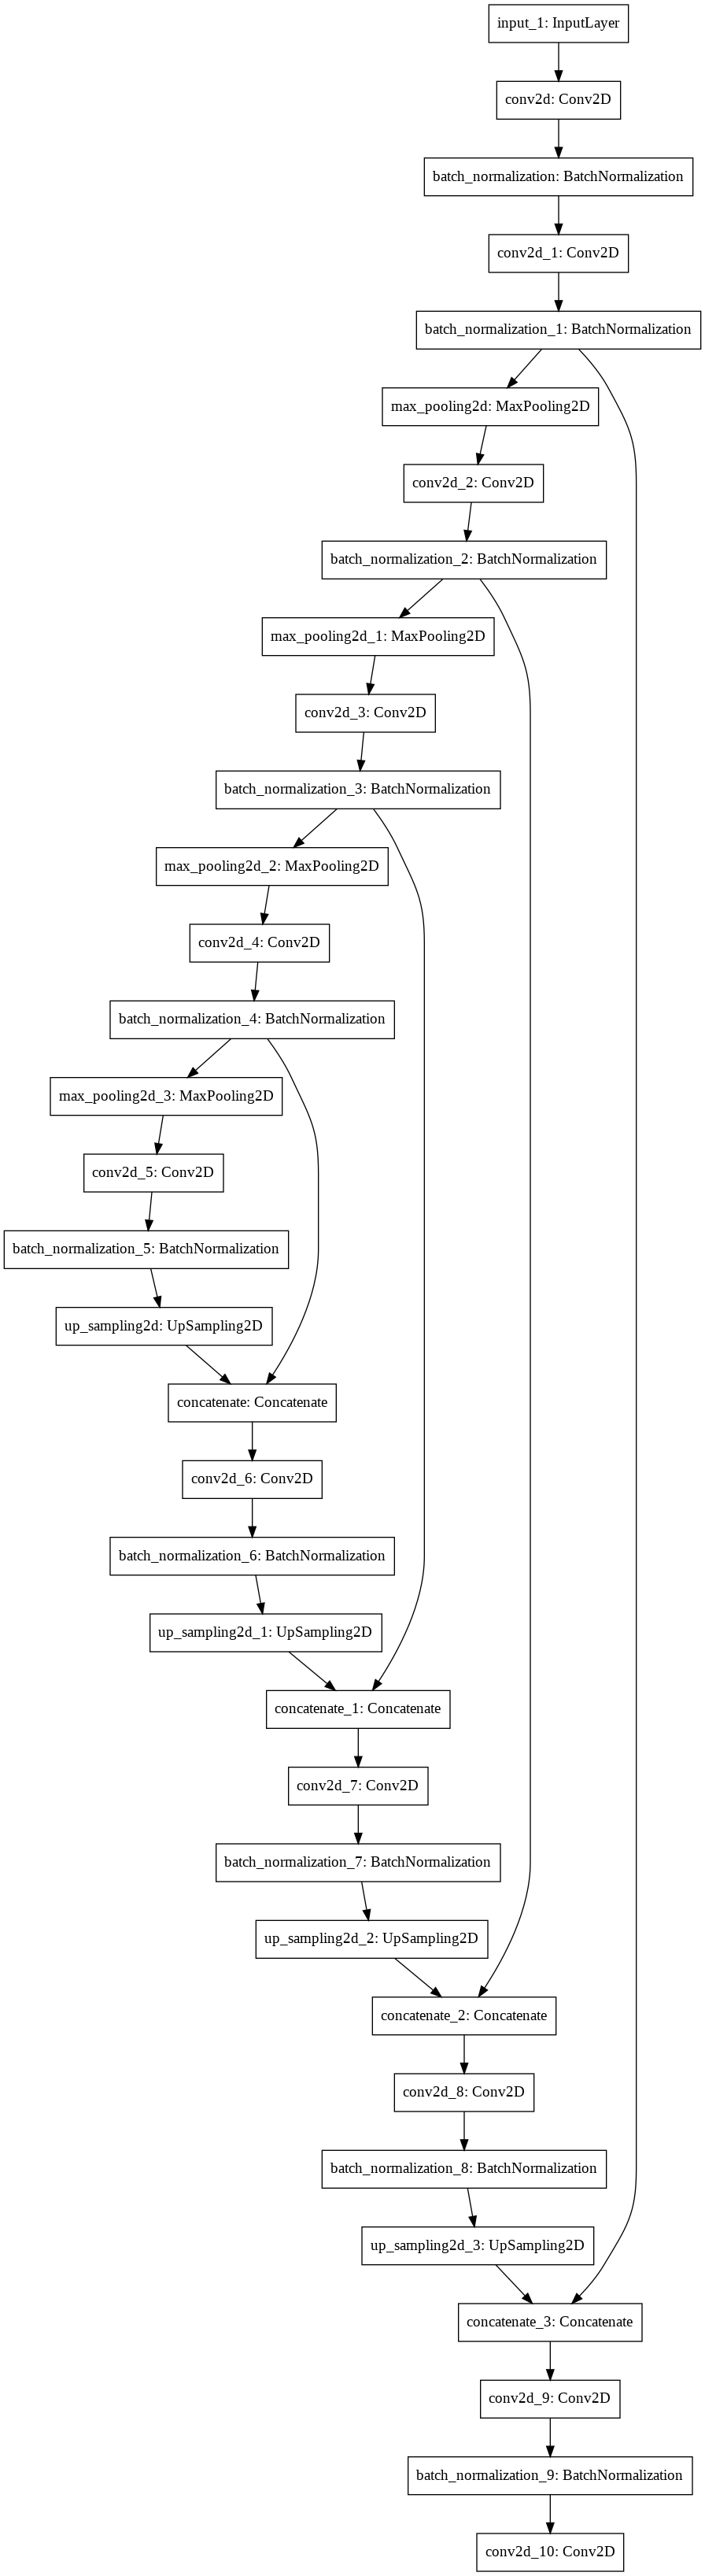

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(seg_model)

In [ ]:
seg_model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', #focal_tversky, 
                  metrics = ['accuracy'] #tversky]
                 )

In [ ]:
epoch = 20
shift = 0 
filename = 'drive/MyDrive/MRI_UNET_bce_' + str(epoch+shift) + '.h5' 
if os.path.exists(filename): 
  #del seg_model
  seg_model = load_model(filename)
  print('file exists!')
else: 
  history = seg_model.fit(training_generator, epochs = epoch , validation_data = validation_generator) # ,callbacks = [checkpointer, earlystopping])
  seg_model.save(filename)
 
 
image_out = []
tumor_out = []
pred_out = []
label_out = []
k = 10
for (i, j) in zip(X_test.IMAGE[:k], X_test.MASK[:k]):
  img = io.imread(i)
  img = img /255.
  #img = np.array(img)
  img = img.reshape(1, 256,256, 3)
  tumor = seg_model.predict(img)
  if np.argmax(tumor) == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
    continue
 
  img = io.imread(i) 
  x = np.empty((1,256,256,3)) 
  img = np.array(img, dtype = np.float64)
 
  img -= img.mean()
  img /= img.std()
  x[0,] = img
  predict = seg_model.predict(x)
    #if the sum of predicted values is equal to 0 then there is no tumour
  if predict.round().astype(int).sum() == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
  else:
    #if the sum of pixel values are more than 0, then there is tumour
    image_out.append(i)
    tumor_out.append(1)
    pred_out.append(predict)
    label_out.append(j)

file exists!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


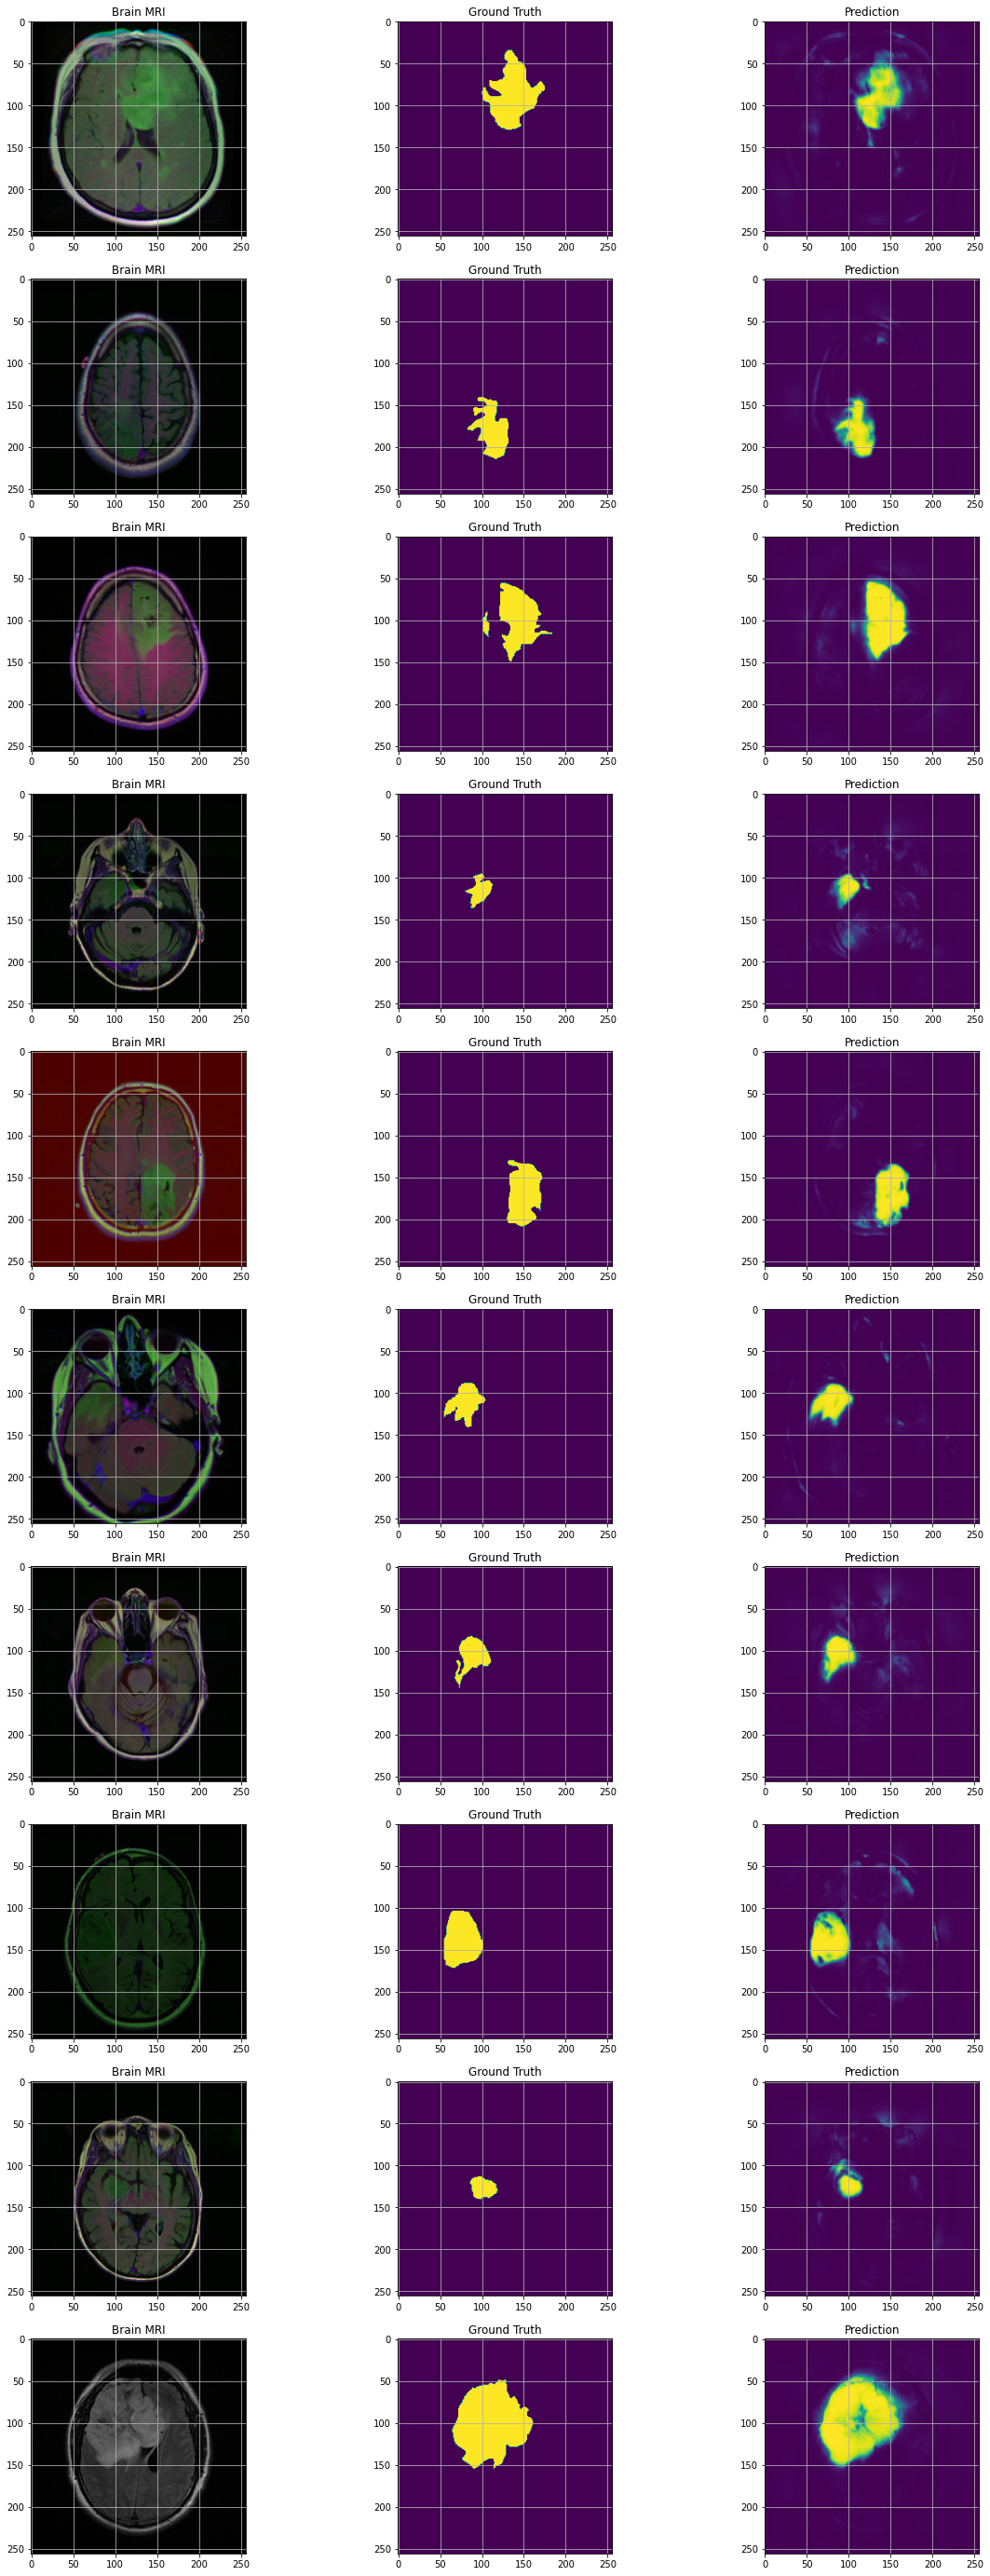

In [ ]:
# epoch = 1
k=10
fig, axs = plt.subplots(10,3, figsize = (20, 50))
for i in range(k):
  if pred_out[i] != 'No mask':
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(plt.imread(image_out[i]))
    axs[i][0].grid()
  
    axs[i][1].title.set_text('Ground Truth')
    axs[i][1].imshow(plt.imread(label_out[i]))
    axs[i][1].grid()
  
    axs[i][2].title.set_text('Prediction')
    axs[i][2].imshow(pred_out[i].reshape(256,256))
    axs[i][2].grid()

In [ ]:
 
image_out = []
tumor_out = []
pred_out = []
label_out = []
k = 10
for (i, j) in zip(X_test.IMAGE[:k], X_test.MASK[:k]):
  img = io.imread(i)
  img = img /255.
  #img = np.array(img)
  img = img.reshape(1, 256,256, 3)
  tumor = seg_model.predict(img)
  if np.argmax(tumor) == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
    continue
 
  img = io.imread(i) 
  x = np.empty((1,256,256,3)) 
  img = np.array(img, dtype = np.float64)
 
  img -= img.mean()
  img /= img.std()
  x[0,] = img
  predict = seg_model.predict(x)
  predict[predict >0.5] = 1.
  predict[predict <0.5] = 0.
    #if the sum of predicted values is equal to 0 then there is no tumour
  if predict.round().astype(int).sum() == 0:
    image_out.append(i)
    tumor_out.append(0)
    pred_out.append('No mask')
    label_out.append(j)
  else:
    #if the sum of pixel values are more than 0, then there is tumour
    image_out.append(i)
    tumor_out.append(1)
    pred_out.append(predict)
    label_out.append(j)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


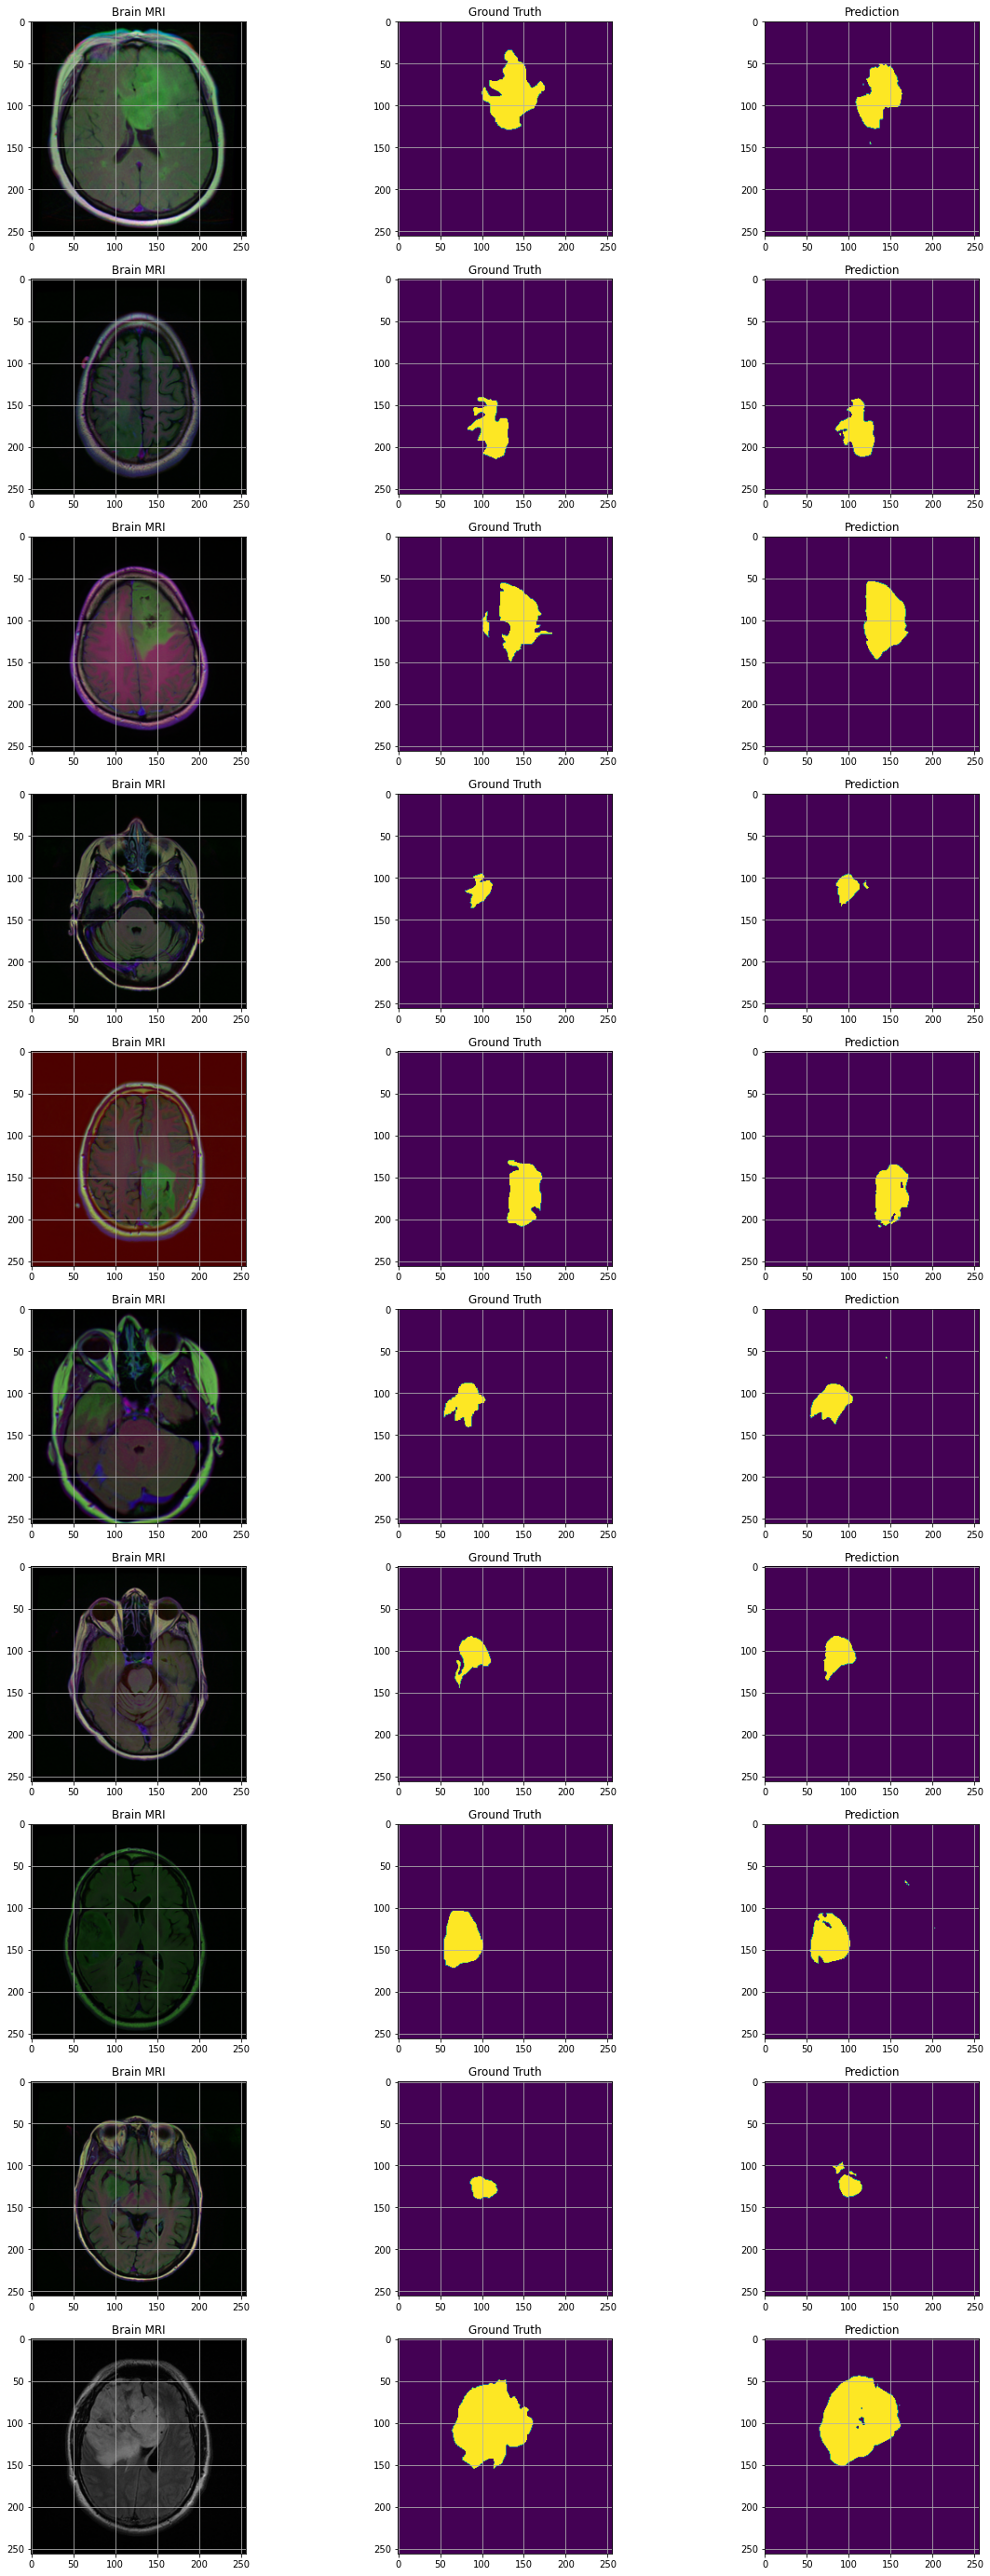

In [ ]:
# epoch = 1
k=10
fig, axs = plt.subplots(10,3, figsize = (20, 50))
for i in range(k):
  if pred_out[i] != 'No mask':
    axs[i][0].title.set_text('Brain MRI')
    axs[i][0].imshow(plt.imread(image_out[i]))
    axs[i][0].grid()
  
    axs[i][1].title.set_text('Ground Truth')
    axs[i][1].imshow(plt.imread(label_out[i]))
    axs[i][1].grid()
  
    axs[i][2].title.set_text('Prediction')
    axs[i][2].imshow(pred_out[i].reshape(256,256))
    axs[i][2].grid()

# Further
- compling model and callbacks functions

- adam = Adam(lr = 0.05, epsilon = 0.1)
- Define a custom loss function for ResUNet model: actual link for refrence (https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py)
 or reference utilities.py
- compare a FCN vs. RES



```
!cp drive/MyDrive/kaggle_token.py ./kaggle_token.py
from kaggle_token import token
api_token = token("3b8")

api_token = {"username":"username@Kaggle_token","key":"Kaggle_token"}

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
#if not os.path.exists("/content/kaggle"):
#    os.makedirs("/content/kaggle")
os.chdir('/content')
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
#!kaggle competitions download -c facial-keypoints-detection
!unzip lgg-mri-segmentation.zip 

#!unzip facial-keypoints-detection.zip 
# df = pd.read_csv('kaggle_3m/data.csv')
clear()
del api_token
!rm kaggle_token.py
```

